In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

### Setting parameters

In [118]:
task = "Reg" # set to appropriate task
LOO = False # set to True to get plots for experiments with LOO
path_to_res = "" # path to the folder where you saved the results
figs_folder = "" # choose the folder you want to save the plots to

algos_Clf = ["LR","RF","NN"] # CLASSIFICATION
algos_Reg = ["RR","RF","NN"] # REGRESSION

n_samples_array = [700,1000,1500,2300,3400,5000,7500,11000]
n_sims = 500
alpha = 0.05

In [119]:
if task=="Clf":
    algos = algos_Clf
else: # task=="Reg"
    algos = algos_Reg
    
methods = []
for algo1 in algos:
    methods.append(algo1)
    for algo2 in algos:
        if algo1 != algo2:
            methods.append(algo1+"_"+algo2)

if LOO:
    methods = ["RR"]

In [111]:
def combine(method,n_samples_array):
    print(method)
    start=time.time()
    list_df = []
    nb_sims = []
    true_sigma = []
    Rcond_sd = []
    for n in n_samples_array:
        current=time.time()
        file = os.path.join(path_to_res,task,method,"n"+str(n),"all_reps.h5")
        file2 = os.path.join(path_to_res,task,method,"n"+str(n),"cond_indiv_err.h5")
        assert os.path.isfile(file)
        assert os.path.isfile(file2)
        if not LOO:
            df = pd.read_hdf(file,"all_reps").iloc[:,(-92):]
        else:
            df = pd.read_hdf(file,"all_reps").iloc[:,(-97):]
        cond_indiv_err = pd.read_hdf(file2,"cond_indiv_err")
        s = df.shape[0]
        list_df.append(df.iloc[:,1:])
        nb_sims.append(s)
        true_sigma.append(cond_indiv_err.std(axis=1)[0])
        Rcond_sd.append(df.iloc[:,0])
        print(n,time.time()-current)
    print(time.time()-start)
    return list_df,nb_sims,true_sigma,Rcond_sd

In [120]:
list_df_dict = {}
sims_dict = {}
true_sigma_dict = {}
Rcond_sd_dict = {}

In [121]:
for key in methods:
    list_df,sims,true_sigma,Rcond_sd = combine(key,n_samples_array)
    list_df_dict[key] = list_df
    sims_dict[key] = sims
    true_sigma_dict[key] = true_sigma
    Rcond_sd_dict[key] = Rcond_sd

RR
700 0.15150213241577148
1000 0.32627344131469727
1500 0.3424644470214844
2300 0.3201134204864502
3400 0.6621870994567871
5000 0.9232821464538574
7500 0.9810216426849365
11000 0.8530147075653076
4.561516284942627
RR_RF
700 0.10968232154846191
1000 0.32884716987609863
1500 0.2657182216644287
2300 0.4238395690917969
3400 0.45462703704833984
5000 0.5424962043762207
7500 0.8654904365539551
11000 1.2584311962127686
4.250162839889526
RR_NN
700 0.16461610794067383
1000 0.16428828239440918
1500 0.33327198028564453
2300 0.41063976287841797
3400 0.6404263973236084
5000 0.45527124404907227
7500 0.8770360946655273
11000 0.9689602851867676
4.01602578163147
RF
700 0.20861554145812988
1000 0.2300732135772705
1500 0.2909095287322998
2300 0.3603854179382324
3400 0.5453002452850342
5000 0.8221333026885986
7500 1.0813748836517334
11000 1.0512042045593262
4.59088659286499
RF_RR
700 0.13085699081420898
1000 0.31685662269592285
1500 0.4581923484802246
2300 0.38794660568237305
3400 0.8502655029296875
5000 

In [60]:
def res(list_df,sims,n_sims):
    z = stats.norm.ppf(1-alpha/2,0,1)
    z2 = z**2
    res_mu = []
    res_sigma = []
    res_sigmaW = []
    res_mu_null = {}
    res_sigma_null = {}
    res_mu_alt = {}
    res_sigma_alt = {}
    nb_sims_null = {}
    nb_sims_alt = {}
    for j in range(7):
        res_mu_null[str(j)] = []
        res_sigma_null[str(j)] = []
        res_mu_alt[str(j)] = []
        res_sigma_alt[str(j)] = []
        nb_sims_null[str(j)] = []
        nb_sims_alt[str(j)] = []
    for i in range(len(list_df)):
        df = list_df[i]
        x = df.mean()
        ns = sims[i]
        res_mu.append(np.array(x))
        res_sigma.append(np.array(df.std()/np.sqrt(ns)))
        l = x-(x+z2/(2*ns))/(1+z2/ns)+(z/(1+z2/ns))*np.sqrt((x*(1-x))/ns+z2/(4*ns**2))
        u = (x+z2/(2*ns))/(1+z2/ns)+(z/(1+z2/ns))*np.sqrt((x*(1-x))/ns+z2/(4*ns**2))-x
        temp = []
        for _,(ll,uu) in enumerate(zip(l,u)):
            temp.append(np.array([ll,uu]))
        res_sigmaW.append(np.array(temp))
        for j in range(7):
            df_null = df.loc[df.iloc[:,(3*j+1)]>=0]
            df_alt = df.loc[df.iloc[:,(3*j+1)]<0]
            x_null = 1-df_null.mean()
            ns_null = df_null.shape[0]
            x_alt = df_alt.mean()
            ns_alt = df_alt.shape[0]
            if ns_null > 25:
                l_null = x_null-(x_null+z2/(2*ns_null))/(1+z2/ns_null)+(z/(1+z2/ns_null))*np.sqrt((x_null*(1-x_null))/ns_null+z2/(4*ns_null**2))
                u_null = (x_null+z2/(2*ns_null))/(1+z2/ns_null)+(z/(1+z2/ns_null))*np.sqrt((x_null*(1-x_null))/ns_null+z2/(4*ns_null**2))-x_null
                res_mu_null[str(j)].append(np.array(x_null))
                temp = []
                for _,(ll,uu) in enumerate(zip(l_null,u_null)):
                    temp.append(np.array([ll,uu]))
                res_sigma_null[str(j)].append(np.array(temp))
            else:
                temp1 = np.empty(df_null.shape[1])
                temp2 = np.empty((df_null.shape[1],2))
                temp1.fill(np.nan)
                temp2.fill(np.nan)
                res_mu_null[str(j)].append(temp1)
                res_sigma_null[str(j)].append(temp2)
            if ns_alt > 25:
                l_alt = x_alt-(x_alt+z2/(2*ns_alt))/(1+z2/ns_alt)+(z/(1+z2/ns_alt))*np.sqrt((x_alt*(1-x_alt))/ns_alt+z2/(4*ns_alt**2))
                u_alt = (x_alt+z2/(2*ns_alt))/(1+z2/ns_alt)+(z/(1+z2/ns_alt))*np.sqrt((x_alt*(1-x_alt))/ns_alt+z2/(4*ns_alt**2))-x_alt
                res_mu_alt[str(j)].append(np.array(x_alt))
                temp = []
                for _,(ll,uu) in enumerate(zip(l_alt,u_alt)):
                    temp.append(np.array([ll,uu]))
                res_sigma_alt[str(j)].append(np.array(temp))
            else:
                temp1 = np.empty(df_alt.shape[1])
                temp2 = np.empty((df_alt.shape[1],2))
                temp1.fill(np.nan)
                temp2.fill(np.nan)
                res_mu_alt[str(j)].append(temp1)
                res_sigma_alt[str(j)].append(temp2)
            nb_sims_null[str(j)].append(ns_null)
            nb_sims_alt[str(j)].append(ns_alt)
    for j in range(7):
        res_mu_null[str(j)] = np.array(res_mu_null[str(j)])
        res_sigma_null[str(j)] = np.array(res_sigma_null[str(j)])
        res_mu_alt[str(j)] = np.array(res_mu_alt[str(j)])
        res_sigma_alt[str(j)] = np.array(res_sigma_alt[str(j)])
    return np.array(res_mu),np.array(res_sigma),np.array(res_sigmaW),res_mu_null,res_sigma_null,res_mu_alt,res_sigma_alt,nb_sims_null,nb_sims_alt

In [122]:
res_mu_dict = {}
res_sigma_dict = {}
res_sigmaW_dict = {}
res_mu_null_dict = {}
res_sigma_null_dict = {}
res_mu_alt_dict = {}
res_sigma_alt_dict = {}
nb_sims_null_dict = {}
nb_sims_alt_dict = {}

In [124]:
for key in methods:
    res_mu,res_sigma,res_sigmaW,res_mu_null,res_sigma_null,res_mu_alt,res_sigma_alt,nb_sims_null,nb_sims_alt = res(list_df_dict[key],sims_dict[key],n_sims)
    res_mu_dict[key] = res_mu
    res_sigma_dict[key] = res_sigma
    res_sigmaW_dict[key] = res_sigmaW
    if ("_" in key):    
        res_mu_null_dict[key] = res_mu_null
        res_sigma_null_dict[key] = res_sigma_null
        res_mu_alt_dict[key] = res_mu_alt
        res_sigma_alt_dict[key] = res_sigma_alt
        nb_sims_null_dict[key] = nb_sims_null
        nb_sims_alt_dict[key] = nb_sims_alt

In [29]:
def plot_coverage_and_width(method, res_mu, res_sigma, res_sigmaW, n_samples_array, n_sims, alpha):
    fig = plt.figure(figsize=(16,5))

    res_mu = res_mu[:,21:]
    res_sigma = res_sigma[:,21:]
    res_sigmaW = res_sigmaW[:,21:]
    
    lw = 2
    fmt = ""
    
    plt.subplot(1,2,1)
    ax1 = plt.gca()
    ax1.tick_params(axis="both",which="major",labelsize=12.5)
#     plt.errorbar(n_samples_array, res_mu[:,0], yerr=res_sigmaW[:,0].T, label="CV CLT (Ours)",
#                  linestyle="solid",linewidth=lw,fmt=fmt) # sigma_in
    plt.errorbar(n_samples_array, res_mu[:,2], yerr=res_sigmaW[:,2].T, label="CV CLT (Ours)",
                 linestyle="solid",linewidth=lw,fmt=fmt) # sigma_out
    plt.errorbar(n_samples_array, res_mu[:,4], yerr=res_sigmaW[:,4].T, label="Hold-out CLT",
                 linestyle="dashed",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,6], yerr=res_sigmaW[:,6].T, label="CV $t$",
                 linestyle="dashdot",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,10], yerr=res_sigmaW[:,10].T, label="Rep. train-val $t$",
                 linestyle=(0, (3, 5, 1, 5)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,12], yerr=res_sigmaW[:,12].T, label="Corr. rep. train-val $t$",
                 linestyle=(0, (3, 1, 1, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,8], yerr=res_sigmaW[:,8].T, label="5x2 CV",
                 linestyle=(0, (5, 1)),linewidth=lw,fmt=fmt)
    plt.xscale("log")
    plt.hlines(1-alpha,n_samples_array[0]-100,n_samples_array[-1]+1500, linestyles="dotted",linewidth=lw)
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax1.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Coverage probability",fontsize=14)
    ax1.set_ylim(0.77,1)
#     plt.xticks([], [])
    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
#     ax1.legend(handles,labels,fontsize=12,ncol=2,handlelength=3)
    
    plt.subplot(1,2,2)
    ax2 = plt.gca()
    ax2.tick_params(axis="both",which="major",labelsize=12.5)
#     plt.errorbar(n_samples_array, res_mu[:,1], yerr=2*res_sigma[:,1], label="CV CLT (Ours)",
#                  linestyle="solid",linewidth=lw,fmt=fmt) # sigma_in
    plt.errorbar(n_samples_array, res_mu[:,3], yerr=2*res_sigma[:,3], label="CV CLT (Ours)",
                 linestyle="solid",linewidth=lw,fmt=fmt) # sigma_out
    plt.errorbar(n_samples_array, res_mu[:,5], yerr=2*res_sigma[:,5], label="Hold-out CLT",
                 linestyle="dashed",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,7], yerr=2*res_sigma[:,7], label="CV $t$",
                 linestyle="dashdot",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,11], yerr=2*res_sigma[:,11], label="Rep. train-val $t$",
                 linestyle=(0, (3, 5, 1, 5)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,13], yerr=2*res_sigma[:,13], label="Corr. rep. train-val $t$",
                 linestyle=(0, (3, 1, 1, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,9], yerr=2*res_sigma[:,9], label="5x2 CV",
                 linestyle=(0, (5, 1)),linewidth=lw,fmt=fmt)
    plt.xscale("log")
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax2.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Width",fontsize=14)
    if task=="Reg":
        ax2.set_ylim(0.18,1.9)
    else: # task=="Clf"
        ax2.set_ylim(0.015,0.17)
#     plt.xticks([], [])
    handles, labels = ax2.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax2.legend(handles,labels,fontsize=12,handlelength=3)

    plt.show()
    fig.savefig(os.path.join(figs_folder,task+"-"+method+".pdf"),
                bbox_inches = 'tight', pad_inches = 0.001)

In [116]:
def plot_coverage_and_width_LOO(method, res_mu, res_sigma, res_sigmaW, n_samples_array, n_sims, alpha):
    fig = plt.figure(figsize=(16,5))

    res_mu = res_mu[:,24:]
    res_sigma = res_sigma[:,24:]
    res_sigmaW = res_sigmaW[:,24:]
    
    lw = 2
    fmt = ""
    
    plt.subplot(1,2,1)
    ax1 = plt.gca()
    ax1.tick_params(axis="both",which="major",labelsize=12.5)
    plt.errorbar(n_samples_array, res_mu[:,2], yerr=res_sigmaW[:,2].T, label="CV CLT (Ours)",
                 linestyle="solid",linewidth=lw,fmt=fmt) # sigma_out
    plt.errorbar(n_samples_array, res_mu[:,4], yerr=res_sigmaW[:,4].T, label="Hold-out CLT",
                 linestyle="dashed",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,6], yerr=res_sigmaW[:,6].T, label="CV $t$ (Dietterich)",
                 linestyle="dashdot",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,10], yerr=res_sigmaW[:,10].T, label="Rep. train-val $t$ (N&B)",
                 linestyle=(0, (3, 5, 1, 5)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,12], yerr=res_sigmaW[:,12].T, label="Corr. rep. train-val $t$ (N&B)",
                 linestyle=(0, (3, 1, 1, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,8], yerr=res_sigmaW[:,8].T, label="5x2 CV (Dietterich)",
                 linestyle=(0, (5, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,14], yerr=res_sigmaW[:,14].T, label="CV CLT (LOOCV)",
                 linestyle="solid",linewidth=lw,fmt=fmt,color="olive") # sigma_out
    plt.xscale("log")
    plt.hlines(1-alpha,n_samples_array[0]-100,n_samples_array[-1]+1500, linestyles="dotted",linewidth=lw)
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax1.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Coverage probability",fontsize=14)
    ax1.set_ylim(0.77,1)
#     plt.xticks([], [])
    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
#     ax1.legend(handles,labels,fontsize=12,ncol=2,handlelength=3)
    
    plt.subplot(1,2,2)
    ax2 = plt.gca()
    ax2.tick_params(axis="both",which="major",labelsize=12.5)
    plt.errorbar(n_samples_array, res_mu[:,3], yerr=2*res_sigma[:,3], label="CV CLT (Ours)",
                 linestyle="solid",linewidth=lw,fmt=fmt) # sigma_out
    plt.errorbar(n_samples_array, res_mu[:,5], yerr=2*res_sigma[:,5], label="Hold-out CLT",
                 linestyle="dashed",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,7], yerr=2*res_sigma[:,7], label="CV $t$",
                 linestyle="dashdot",linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,11], yerr=2*res_sigma[:,11], label="Rep. train-val $t$",
                 linestyle=(0, (3, 5, 1, 5)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,13], yerr=2*res_sigma[:,13], label="Corr. rep. train-val $t$",
                 linestyle=(0, (3, 1, 1, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,9], yerr=2*res_sigma[:,9], label="5x2 CV",
                 linestyle=(0, (5, 1)),linewidth=lw,fmt=fmt)
    plt.errorbar(n_samples_array, res_mu[:,15], yerr=2*res_sigma[:,15], label="LOOCV CLT (Ours)",
                 linestyle="solid",linewidth=lw,fmt=fmt,color="olive") # sigma_out
    plt.xscale("log")
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax2.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Width",fontsize=14)
    ax2.set_ylim(0.18,1.9)
#     plt.xticks([], [])
    handles, labels = ax2.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax2.legend(handles,labels,fontsize=12,handlelength=3)
    
    plt.show()
    fig.savefig(os.path.join(figs_folder,task+"-"+method+"-LOOCV.pdf"),
                bbox_inches = 'tight', pad_inches = 0.001)

In [74]:
def plot_comparison(method, res_mu, res_sigma, res_sigmaW, res_mu_nullo, res_sigma_nullo,
                    res_mu_alto, res_sigma_alto, n_samples_array,n_sims,alpha):
    fig = plt.figure(figsize=(16,5))

    lw = 2
    cs = 4
    ct = 2
    fmt = ""
    
    res_mu = res_mu[:,21:]
    res_sigma = res_sigma[:,21:]
    res_sigmaW = res_sigmaW[:,21:]
    res_mu_null = {}
    res_sigma_null = {}
    res_mu_alt = {}
    res_sigma_alt = {}
    for j in range(7):
        res_mu_null[str(j)] = res_mu_nullo[str(j)][:,21:]
        res_sigma_null[str(j)] = res_sigma_nullo[str(j)][:,21:]
        res_mu_alt[str(j)] = res_mu_alto[str(j)][:,21:]
        res_sigma_alt[str(j)] = res_sigma_alto[str(j)][:,21:]
    

    plt.subplot(1,2,1)
    ax1 = plt.gca()
    ax1.tick_params(axis="both",which="major",labelsize=12.5)
#     plt.errorbar(n_samples_array, res_mu_null["0"][:,14], yerr=res_sigma_null["0"][:,14].T,
#                  label="CV CLT (Ours)",linestyle="solid", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct) # sigma_in
    plt.errorbar(n_samples_array, res_mu_null["1"][:,18], yerr=res_sigma_null["1"][:,18].T,
                 label="CV CLT (Ours)",linestyle="solid", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct) # sigma_out
    plt.errorbar(n_samples_array, res_mu_null["2"][:,22], yerr=res_sigma_null["2"][:,22].T,
                 label="Hold-out CLT",linestyle="dashed",linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_null["3"][:,26], yerr=res_sigma_null["3"][:,26].T,
                 label="CV $t$",linestyle="dashdot",linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_null["5"][:,34], yerr=res_sigma_null["5"][:,34].T,
                 label="Rep. train-val $t$",linestyle=(0, (3, 5, 1, 5)),linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_null["6"][:,38], yerr=res_sigma_null["6"][:,38].T,
                 label="Corr. rep. train-val $t$",linestyle=(0, (3, 1, 1, 1)),linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_null["4"][:,30], yerr=res_sigma_null["4"][:,30].T,
                 label="5x2 CV",linestyle=(0, (5, 1)),linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.xscale("log")
    plt.hlines(alpha, n_samples_array[0]-100, n_samples_array[-1]+1500, linestyles="dotted", linewidth=lw)
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax1.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Size",fontsize=14)
#     ax1.set_ylim(-0.001,0.151) # for RR_NN in Reg
    ax1.set_ylim(-0.001,0.101)
#     plt.xticks([], [])
    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
#     ax1.legend(handles,labels,fontsize=12,handlelength=3)
    
    plt.subplot(1,2,2)
    ax2 = plt.gca()
    ax2.tick_params(axis="both",which="major",labelsize=12.5)
#     plt.errorbar(n_samples_array, res_mu_alt["0"][:,15], yerr=res_sigma_alt["0"][:,15].T,
#                  label="CV CLT (Ours)",linestyle="solid", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct) # sigma_in
    plt.errorbar(n_samples_array, res_mu_alt["1"][:,19], yerr=res_sigma_alt["1"][:,19].T,
                 label="CV CLT (Ours)",linestyle="solid", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct) # sigma_out
    plt.errorbar(n_samples_array, res_mu_alt["2"][:,23], yerr=res_sigma_alt["2"][:,23].T,
                 label="Hold-out CLT",linestyle="dashed", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_alt["3"][:,27], yerr=res_sigma_alt["3"][:,27].T,
                 label="CV $t$",linestyle="dashdot", linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_alt["5"][:,35], yerr=res_sigma_alt["5"][:,35].T,
                 label="Rep. train-val $t$",linestyle=(0, (3, 5, 1, 5)), linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_alt["6"][:,39], yerr=res_sigma_alt["6"][:,39].T,
                 label="Corr. rep. train-val $t$",linestyle=(0, (3, 1, 1, 1)), linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.errorbar(n_samples_array, res_mu_alt["4"][:,31], yerr=res_sigma_alt["4"][:,31].T,
                 label="5x2 CV",linestyle=(0, (5, 1)), linewidth=lw,fmt=fmt, capsize=cs, capthick=ct)
    plt.xscale("log")
    plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
    ax2.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
    plt.ylabel("Power",fontsize=14)
    ax2.set_ylim(-0.01,1.01)
    handles, labels = ax2.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax2.legend(handles,labels,fontsize=12,handlelength=3)
    
    plt.show()
    fig.savefig(os.path.join(figs_folder,task+"-"+method+".pdf"),
                bbox_inches = 'tight', pad_inches = 0.001)

### Single algo CV CI - Clf

#### Run when you have selected the Clf task

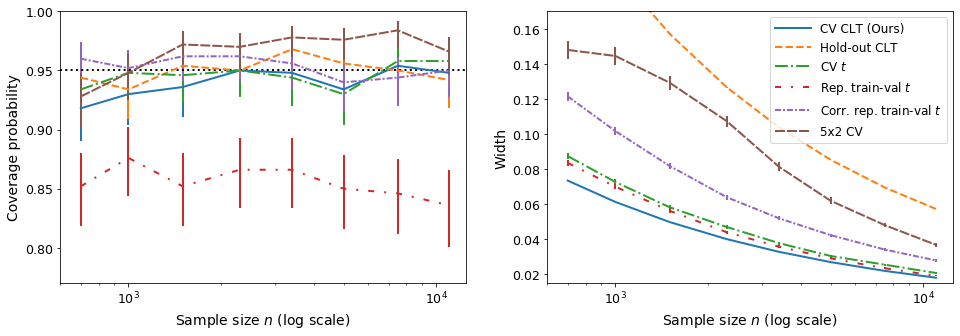

In [32]:
key = "LR"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

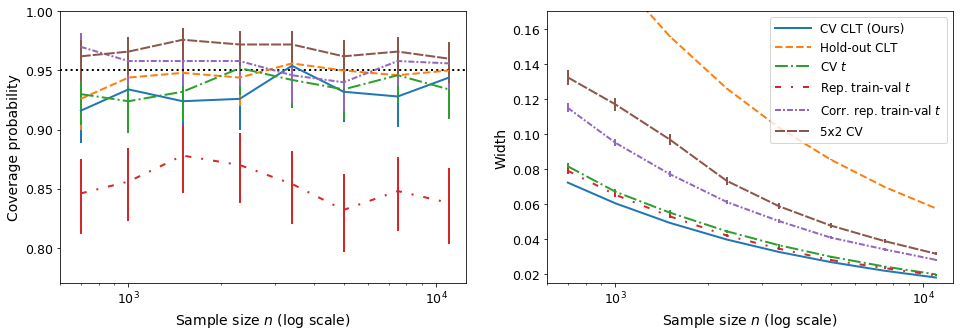

In [33]:
key = "RF"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

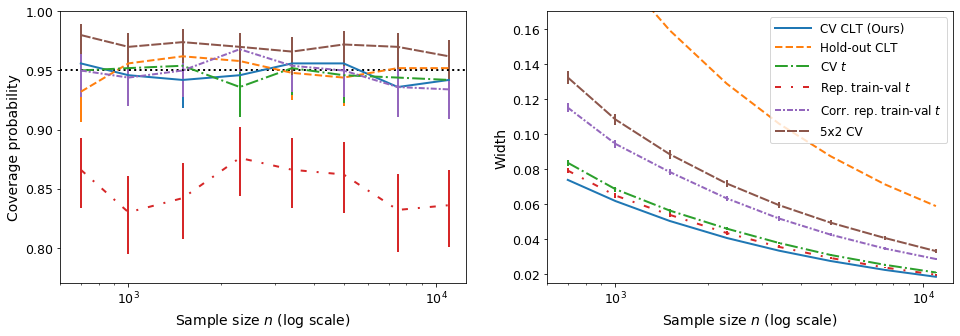

In [34]:
key = "NN"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

### Single algo CV CI - Reg

#### Run when you have selected the Reg task

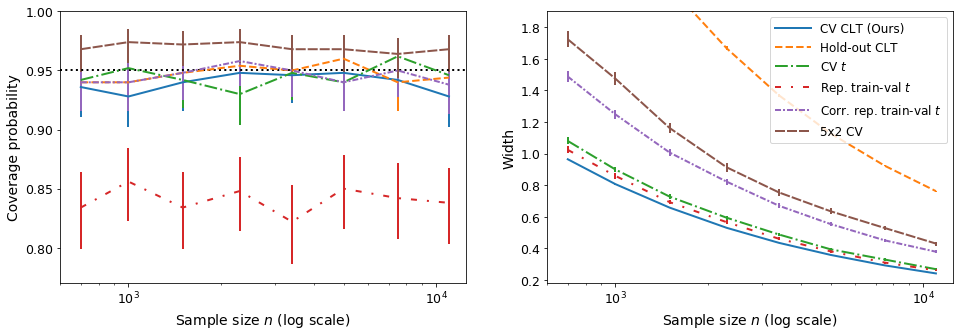

In [64]:
key = "RF"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

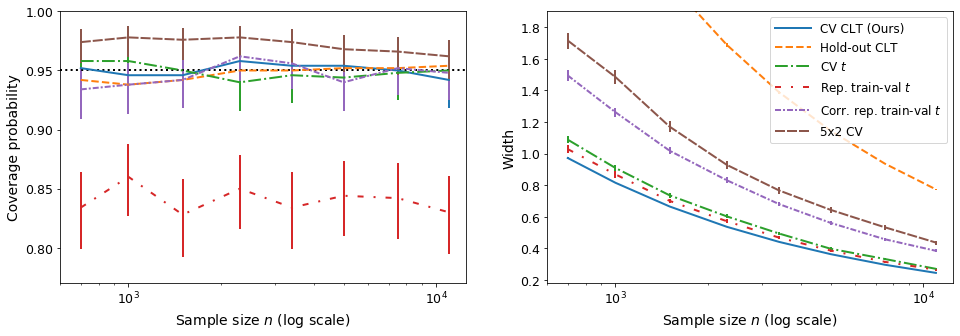

In [65]:
key = "RR"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

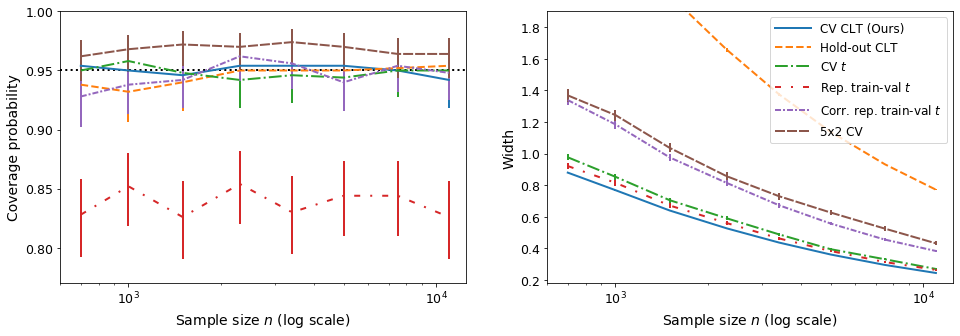

In [66]:
key = "NN"
plot_coverage_and_width(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

### Single algo CV CI - RR LOOCV

#### Run when you have selected the Reg task and LOO option

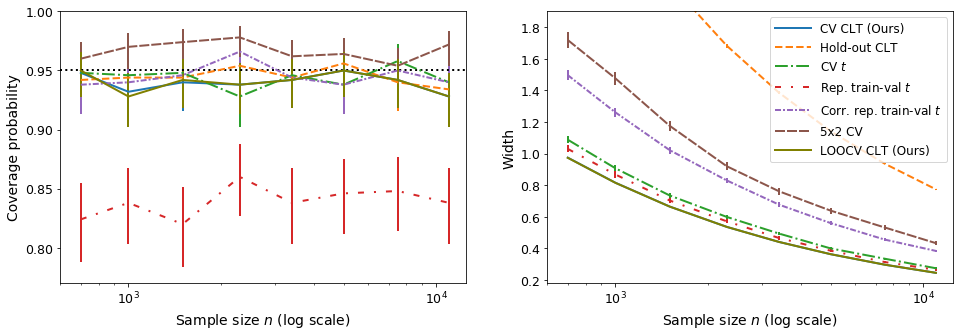

In [117]:
key = "RR"
plot_coverage_and_width_LOO(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],n_samples_array,n_sims,alpha)

### Algo comparison - Clf

#### Run when you have selected the Clf task

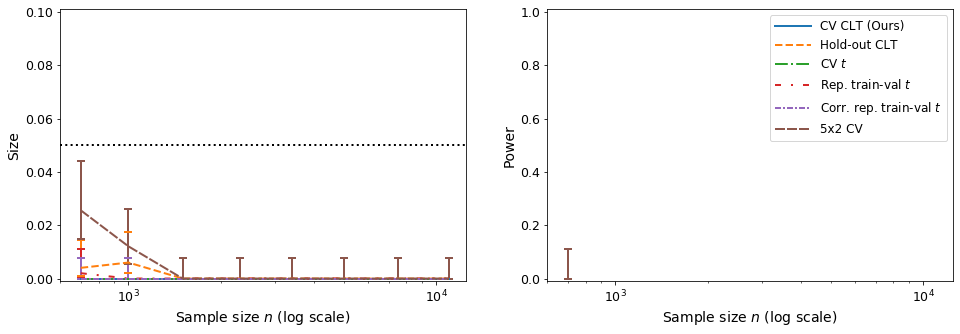

In [49]:
key = "NN_LR"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

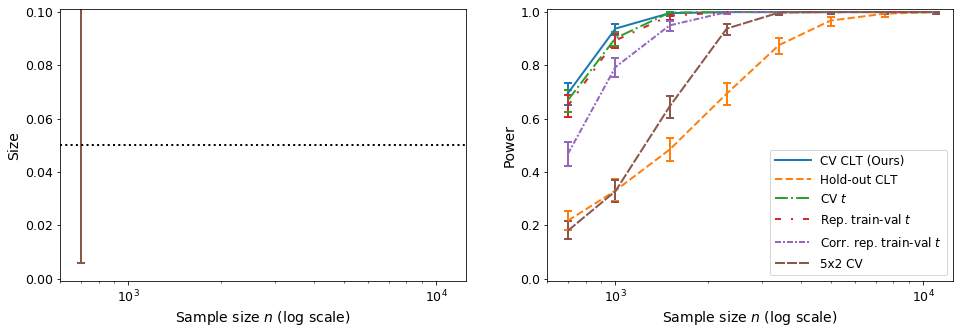

In [50]:
key = "LR_NN"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

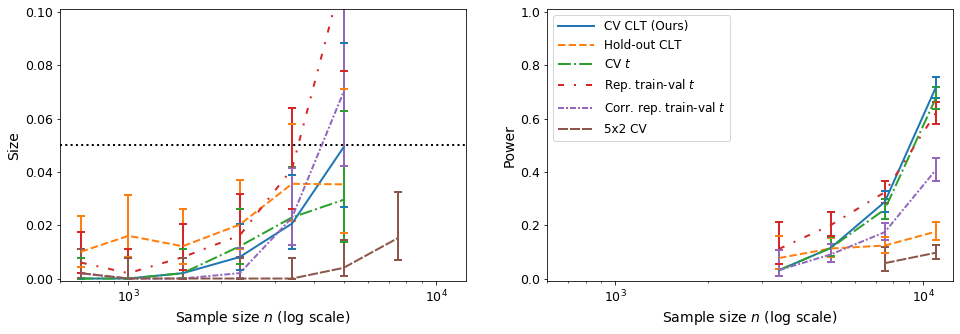

In [51]:
key = "LR_RF"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

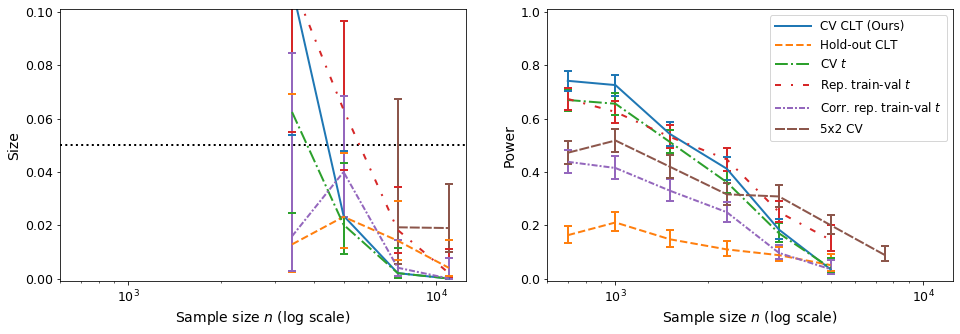

In [52]:
key = "RF_LR"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

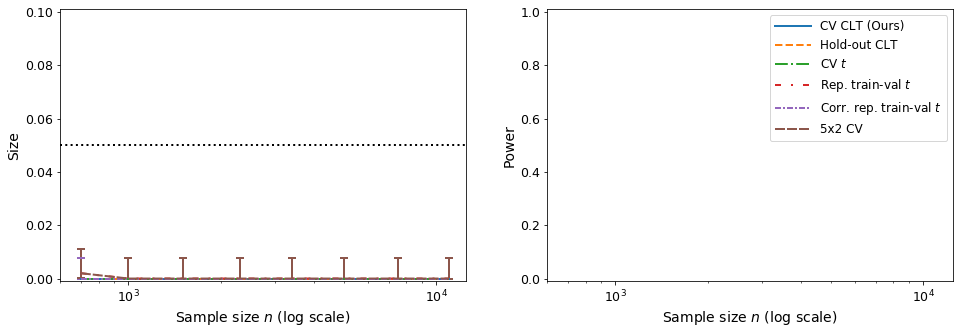

In [53]:
key = "NN_RF"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

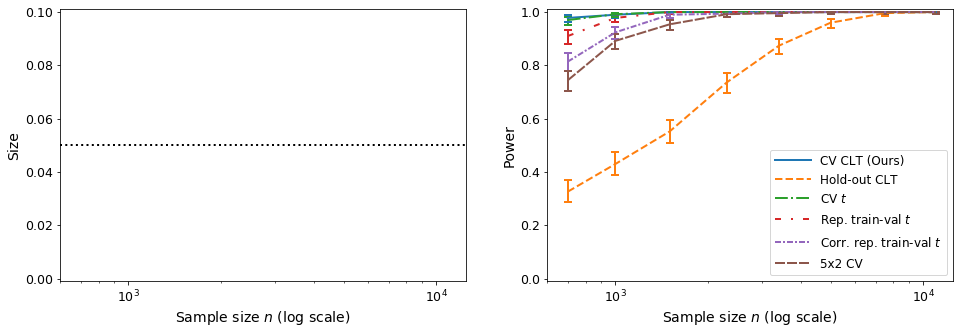

In [54]:
key = "RF_NN"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

### Algo comparison - Reg

#### Run when you have selected the Reg task

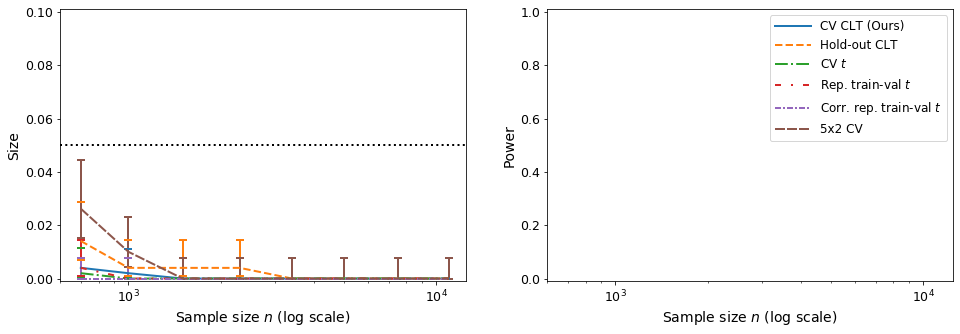

In [67]:
key = "RR_RF"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

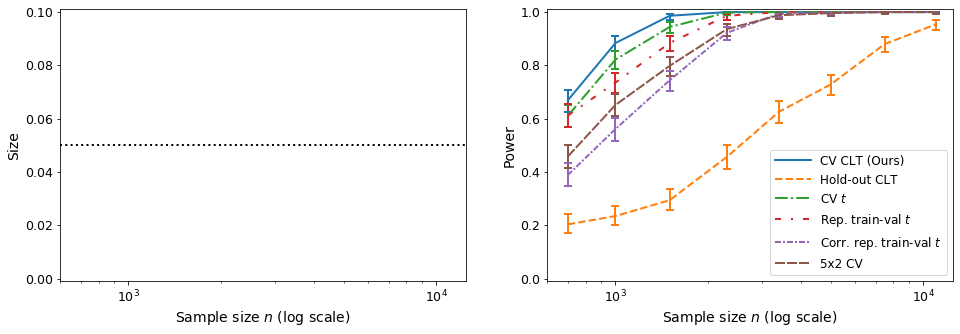

In [68]:
key = "RF_RR"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

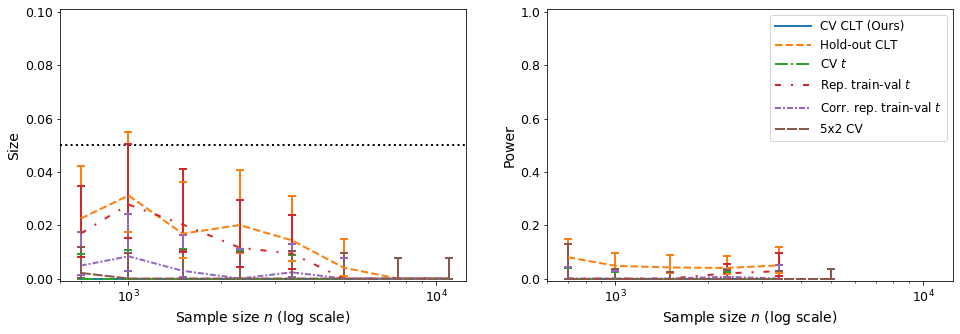

In [69]:
key = "NN_RR"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

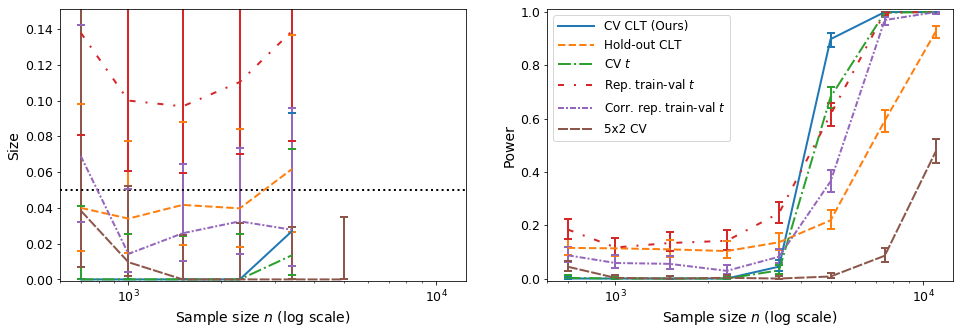

In [75]:
key = "RR_NN"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)
# change the limits of the y-axis in plot_comparison to have the same limits as those in the paper

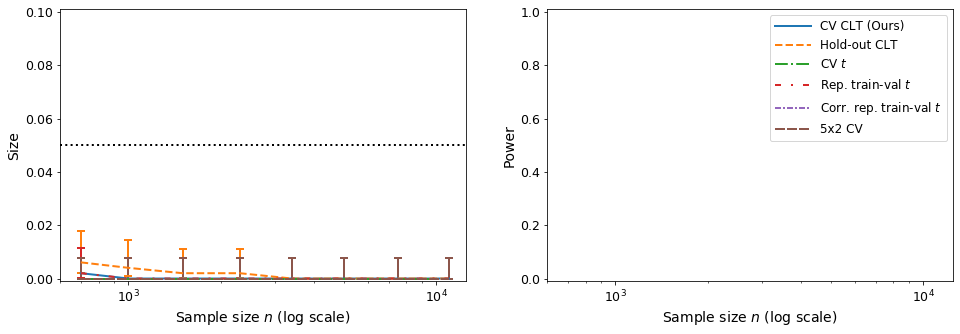

In [71]:
key = "NN_RF"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

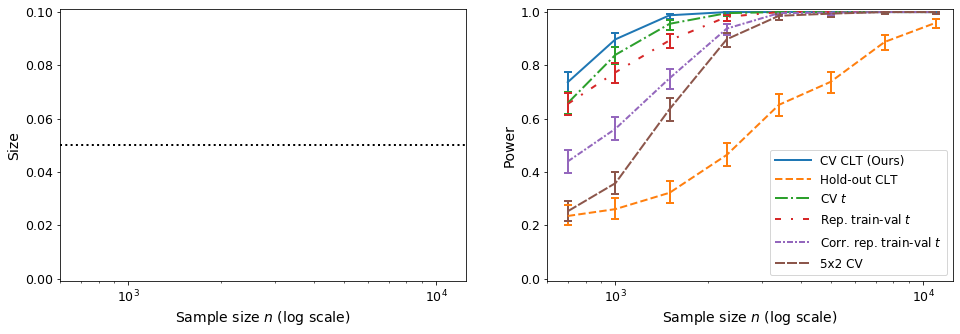

In [73]:
key = "RF_NN"
plot_comparison(key,res_mu_dict[key],res_sigma_dict[key],res_sigmaW_dict[key],
                res_mu_null_dict[key],res_sigma_null_dict[key],
                res_mu_alt_dict[key],res_sigma_alt_dict[key],
                n_samples_array,n_sims,alpha)

### Plotting the variance of $\sqrt{n}(\hat R_n - R_n)/\sigma_n$

In [76]:
def var_values(key):
    res = []
    j = 1
    for i in range(len(n_samples_array)):
        n = n_samples_array[i]
        temp = (list_df_dict[key][i].iloc[:,3*j]-list_df_dict[key][i].iloc[:,3*j+1])*(np.sqrt(n)/true_sigma_dict[key][i])
        res.append(temp.var())
    return res

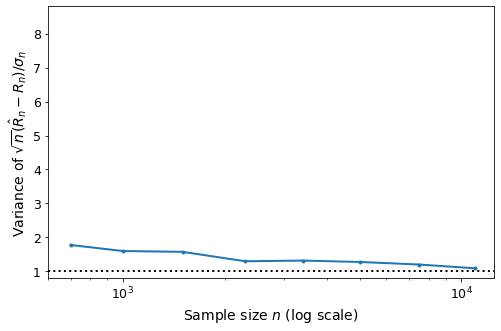

In [78]:
key = "NN_RF"
var_vals = var_values(key)
fig = plt.figure(figsize=(8,5))
plt.xscale("log")
plt.plot(n_samples_array,var_vals,".-", linewidth=2)
ax = plt.gca()
ax.tick_params(axis="both",which="major",labelsize=12.5)
ax.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
ax.set_ylim(0.8,8.8)
plt.hlines(1, n_samples_array[0]-100, n_samples_array[-1]+1500, linestyles="dotted", linewidth=2)
plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
plt.ylabel("Variance of $\sqrt{n}(\hat R_n - R_n)/\sigma_n$",fontsize=14)
plt.show()
fig.savefig(os.path.join(figs_folder,task+"-"+key+"-var.pdf"),
            bbox_inches = 'tight', pad_inches = 0.001)

#### We left the chunks below to show the plots we obtained when comparing variances but to actually recover them, you need to run the first chunk below when you have loaded the Reg results in the stabilized case and the second chunk below when you have loaded them in the destabilized case. Then you will be able to run the third chunk below.

In [79]:
var_values1_1 = var_values("NN_RF")
var_values1_2 = var_values("NN")
var_values1_3 = var_values("RF")

In [88]:
var_values2_1 = var_values("NN_RF")
var_values2_2 = var_values("NN")
var_values2_3 = var_values("RF")

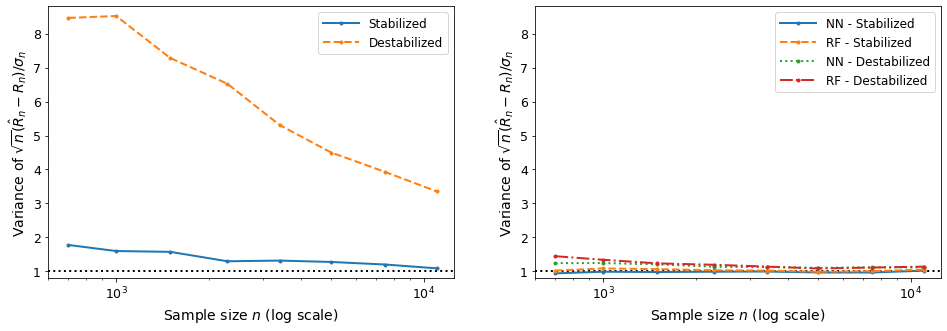

In [125]:
fig = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.xscale("log")
plt.plot(n_samples_array,var_values1_1,".-", linewidth=2, label="Stabilized")
plt.plot(n_samples_array,var_values2_1,".-", linewidth=2, label="Destabilized",linestyle="dashed")
ax1 = plt.gca()
ax1.tick_params(axis="both",which="major",labelsize=12.5)
ax1.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
ax1.set_ylim(0.8,8.8)
plt.hlines(1, n_samples_array[0]-100, n_samples_array[-1]+1500, linestyles="dotted", linewidth=2)
plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
plt.ylabel("Variance of $\sqrt{n}(\hat R_n - R_n)/\sigma_n$",fontsize=14)
ax1.legend(fontsize=12,handlelength=3)

plt.subplot(1,2,2)
plt.xscale("log")
plt.plot(n_samples_array,var_values1_2,".-", linewidth=2, label="NN - Stabilized")
plt.plot(n_samples_array,var_values1_3,".-", linewidth=2, label="RF - Stabilized",linestyle="dashed")
plt.plot(n_samples_array,var_values2_2,".-", linewidth=2, label="NN - Destabilized",linestyle="dotted")
plt.plot(n_samples_array,var_values2_3,".-", linewidth=2, label="RF - Destabilized",linestyle="dashdot")
ax2 = plt.gca()
ax2.tick_params(axis="both",which="major",labelsize=12.5)
ax2.set_xlim(n_samples_array[0]-100, n_samples_array[-1]+1500)
plt.hlines(1, n_samples_array[0]-100, n_samples_array[-1]+1500, linestyles="dotted", linewidth=2)
ax2.set_ylim(0.8,8.8)
plt.xlabel("Sample size $n$ (log scale)",fontsize=14)
plt.ylabel("Variance of $\sqrt{n}(\hat R_n - R_n)/\sigma_n$",fontsize=14)
ax2.legend(fontsize=12,handlelength=3)

plt.show()
fig.savefig(os.path.join(figs_folder,"Reg-comp-var.pdf"),
                bbox_inches = 'tight', pad_inches = 0.001)